## Deep learning: Time Series forecasting
**Author:** Samson (linkedin.com/in/samson-niyizurugero-200a19260)


# Deep learning: Time Series forecasting
### Recurent Neural Networks: Develop an LSTM (Long Short-Term Memory)
* Air Pollution data
* Baseline model
* Vanilla LSTM model
* LSTM with scaled data
* StackedLSTM
* LTSM-CNN (optional)


### Populating namespace

In [ ]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Air Pollution dataset ([Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv))
The dataset is collected from the US embassy in Beijing, China. It reports the Air quality and the weather each hour for five(5) years.
The data including the pollutant (PM2.5 concentration) to forecast is described with varibles listed below:
* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* pm2.5: PM2.5 concentration
* DEWP: Dew Point
* TEMP: Temperature
* PRES: Pressure
* cbwd: Combined wind direction
* Iws: Cumulated wind speed
* Is: Cumulated hours of snow
* Ir: Cumulated hours of rain

The Goal is to forecast the pollution at the next hour given history of pollution and weather condition



#### Download [Beijing PM2.5 Data Set](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv)

In [ ]:
!rm pollution.csv
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
!ls

rm: cannot remove 'pollution.csv': No such file or directory
--2024-04-04 07:13:51--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1.92M  --.-KB/s    in 0.06s   

2024-04-04 07:13:51 (32.8 MB/s) - ‘pollution.csv’ saved [2010492/2010492]

pollution.csv  sample_data


In [ ]:
data = pd.read_csv('pollution.csv')
print(data.shape)
# Display the first (5) rows of the dataframe
print(data.head(5))

(43824, 13)
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [ ]:
# Check NAs (missing values) for all the columns
print(data.isna().sum())

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


In [ ]:
# Check date types
date_columns = ['year', 'month', 'day', 'hour']
date_types = data[date_columns].dtypes

print(date_types)

year     int64
month    int64
day      int64
hour     int64
dtype: object


In [ ]:
#Check variable cbwd value occurences using value_counts
cbwd_value_counts = data['cbwd'].value_counts()
print(cbwd_value_counts)

cbwd
SE    15290
NW    14150
cv     9387
NE     4997
Name: count, dtype: int64


In [ ]:
# Load & format date
data = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda d: datetime.strptime(d, '%Y %m %d %H'))
# Drop No(variable) column
data.drop(columns=['No'], inplace=True)
# Fill all the NA with value  0
data.fillna(0, inplace=True)
# label encodeing of cbwd (wind direction feature): categories to numerics
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder() # Create an instance of LabelEncoder
data['cbwd'] = label_encoder.fit_transform(data['cbwd']) # use the fit__transform function to encode the data
cbwd = data['cbwd']
# rename columns
data.rename(columns = {"pm2.5":"pollution","cbwd":"WINDdir","Iws":"WINDsped",	"Is":"SNOW",	"Ir":"RAIN"}, inplace=True)
data.index.name = 'datetime'
data.head()

<ipython-input-7-e47d6505c90e>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=lambda d: datetime.strptime(d, '%Y %m %d %H'))


,pollution,DEWP,TEMP,PRES,WINDdir,WINDsped,SNOW,RAIN
datetime,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1,12.97,0,0


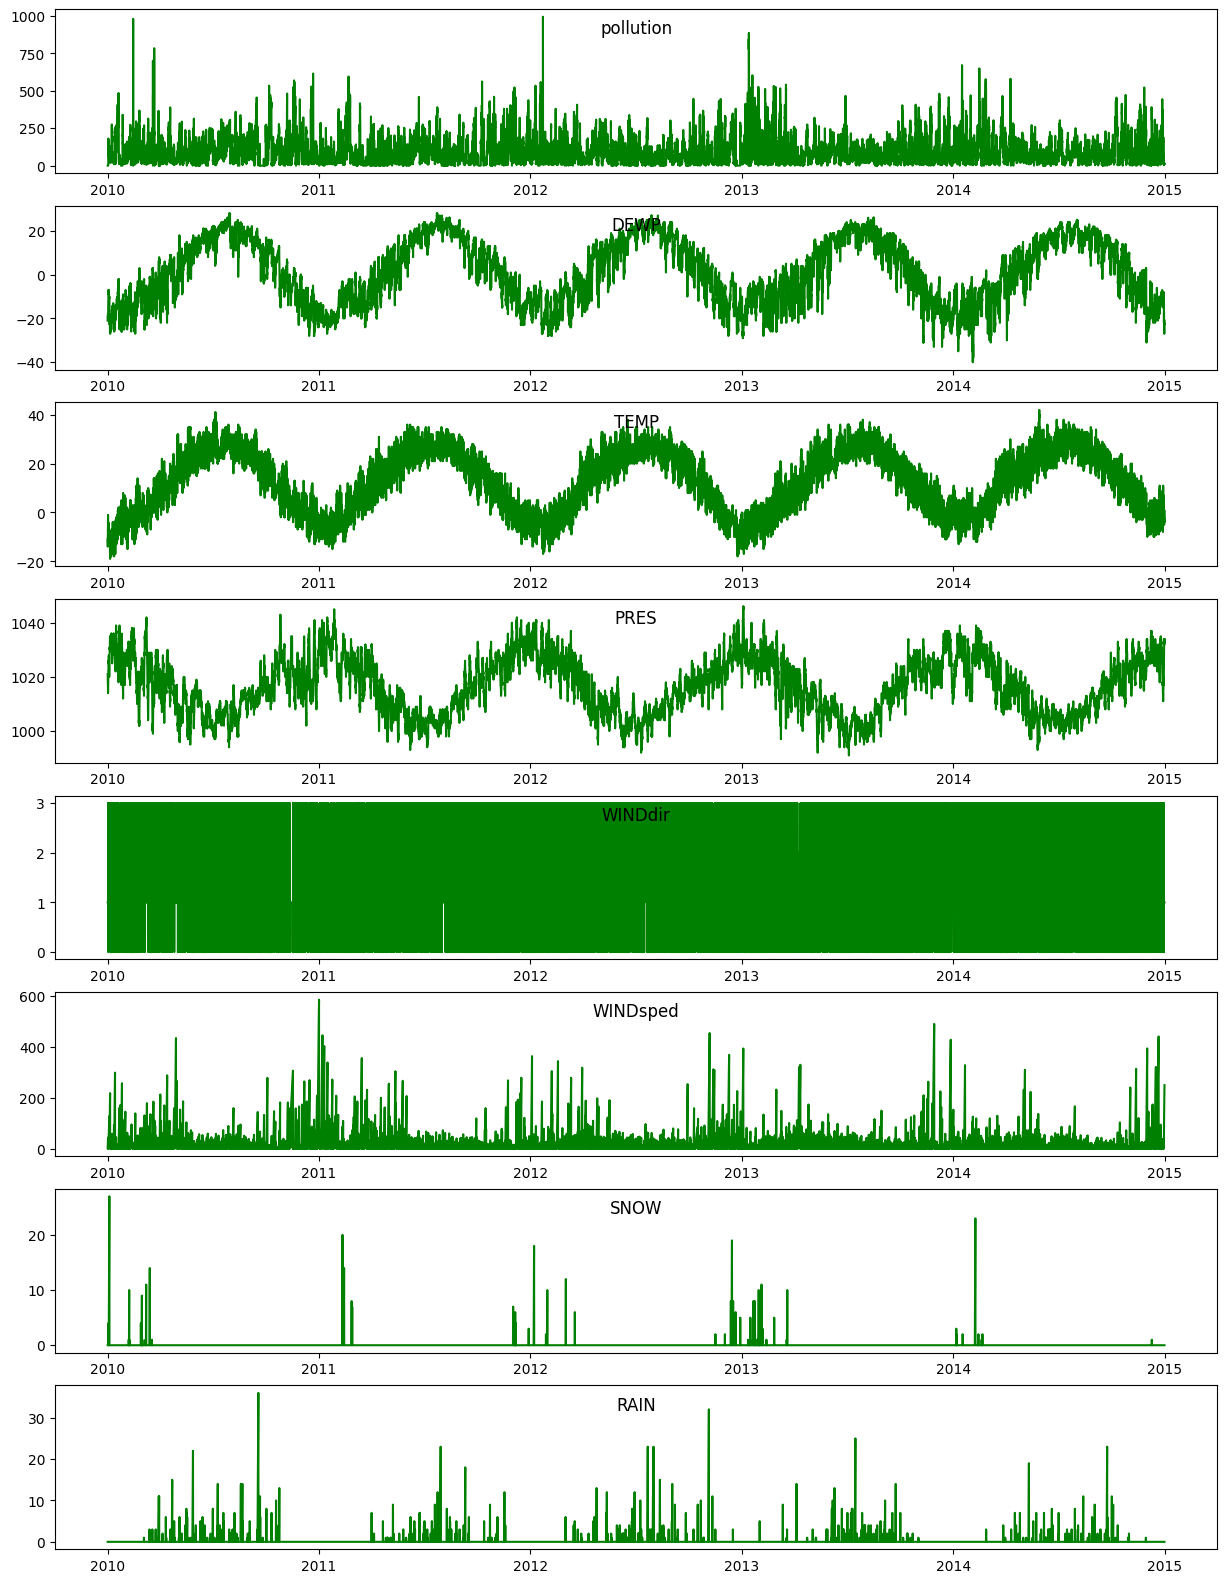

In [ ]:
plt.figure(figsize=(15,20))
list_vars = data.columns #("pollution",	"DEWP",	"TEMP",	"PRES",	"WINDsped",	"SNOW",	"RAIN")
for i, var in enumerate(list_vars):
  plt.subplot(data.shape[1], 1, i+1)
  plt.plot(data[var], color='green')
  plt.title(var,y=0.8)

<Axes: >

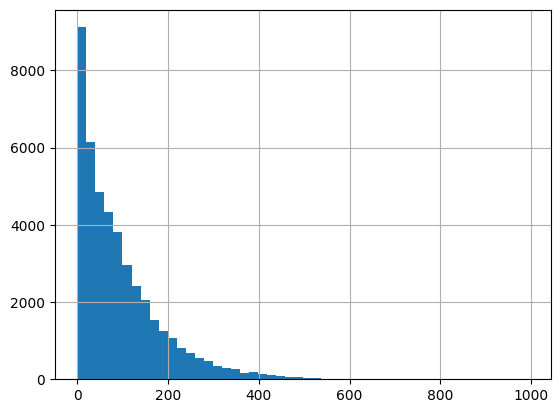

In [ ]:
data.pollution.hist(bins=50)

## Time serie forecasting as supervised learning problem (Regression setting)
* predict the pollution at the next hour (t) given the pollution and weather conditions at the prior time step


#### Prepare the pollution dataset for LSTM algorithm

In [ ]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target=None):
  # History: look-back sequences (t-n, ... t-1)
  stack_history = []
  for i in range(n_history,0,-1):
    df_i = df.shift(i)
    df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
    stack_history =  stack_history + [df_i]
  # target dataframe
  if target is None: df_target = df
  else: df_target = df[target].to_frame()
  # Horizon: step-ahead sequences (t+1, ... t+n)
  stack_horizon = []
  for j in range(n_horizon,0,-1):
    df_j = df_target.shift(j)
    df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
    stack_horizon = [df_j] + stack_horizon
  # Present: t
  df_t = df.copy()
  df_t.columns = [f'{col}_t' for col in df_t.columns]
  # return the concatenated data frame: past+present+future
  return pd.concat(stack_history+[df_t]+stack_horizon, axis=1)

In [ ]:
data_Xy = history_and_horizon_sequencing(data, 3, 1, target='pollution')
print(data_Xy.shape)
data_Xy.dropna(inplace=True)
print(data_Xy.shape)
data_Xy.head()

(43824, 33)
(43821, 33)


,pollution_t-3,DEWP_t-3,TEMP_t-3,PRES_t-3,WINDdir_t-3,WINDsped_t-3,SNOW_t-3,RAIN_t-3,pollution_t-2,DEWP_t-2,...,RAIN_t-1,pollution_t,DEWP_t,TEMP_t,PRES_t,WINDdir_t,WINDsped_t,SNOW_t,RAIN_t,pollution_t+1
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 03:00:00,0.0,-21.0,-11.0,1021.0,1.0,1.79,0.0,0.0,0.0,-21.0,...,0.0,0.0,-21,-14.0,1019.0,1,9.84,0,0,0.0
2010-01-01 04:00:00,0.0,-21.0,-12.0,1020.0,1.0,4.92,0.0,0.0,0.0,-21.0,...,0.0,0.0,-20,-12.0,1018.0,1,12.97,0,0,0.0
2010-01-01 05:00:00,0.0,-21.0,-11.0,1019.0,1.0,6.71,0.0,0.0,0.0,-21.0,...,0.0,0.0,-19,-10.0,1017.0,1,16.10,0,0,0.0
2010-01-01 06:00:00,0.0,-21.0,-14.0,1019.0,1.0,9.84,0.0,0.0,0.0,-20.0,...,0.0,0.0,-19,-9.0,1017.0,1,19.23,0,0,0.0
2010-01-01 07:00:00,0.0,-20.0,-12.0,1018.0,1.0,12.97,0.0,0.0,0.0,-19.0,...,0.0,0.0,-19,-9.0,1017.0,1,21.02,0,0,0.0


#### Baseline v0: persistance modeling
Use observation from the present time step (t) to predict the observation at the next time step (t+1).   

In [ ]:
def baseline_persistance(serie_t):
  # forecast: predict t+1 with value of t
  forecast = serie_t.shift(1)
  return forecast


def compute_performance(test, forecast, start_t=400, end_t=500):
  rmse = np.sqrt(mean_squared_error(test, forecast)) # Compute root mean squared error between test and forecast
  print('RMSE: %.3f' % rmse)
  plt.figure(figsize=(15,5))
  plt.plot(test[start_t:end_t], color='b')
  plt.plot(forecast[start_t:end_t], color='r')

RMSE: 27.568


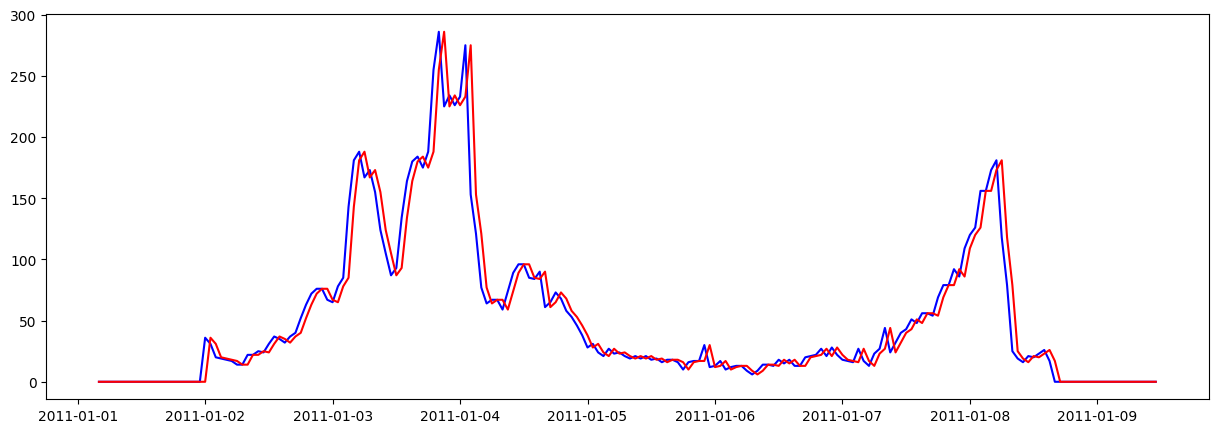

In [ ]:
test_y, persistance_yhat = data_Xy['pollution_t'][1:], baseline_persistance(data_Xy['pollution_t'])[1:]
compute_performance(test_y, persistance_yhat, start_t=365*24, end_t=365*24+200)

#### LSTM model

#### Split data into train and test sets
Build train and test dataset for training the model on the first one(1) year and prediction of the four(4) lastest years

In [ ]:
import random

In [ ]:
def split_train_test(values, n_train_hours = 365*24):
  # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
  random.seed(42)
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features] required for LSTM
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
  return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values)

(8760, 1, 32) (8760,) (35061, 1, 32) (35061,)


#### Build an LSTM model

In [ ]:
def build_lstm_model(input_shape, nb_neurons = 35):
  '''
  train and test: input shape 1 time step with 8 features
  LSTM:
   * nb_neurons: hidden state
   * 1 neuron for output layer for prediction.
  '''
  model = Sequential()

  # Add an LSTM layer with nb_neurons and input_shape=input_shape
  model.add(LSTM(nb_neurons, input_shape=input_shape))



  # Add a Dense layer with one output neuron
  model.add(Dense(1))
  # model compile
  model.compile(loss='mae', optimizer='adam')
  # Train the model
  return model

def train_model(model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0):
  '''
  Generic function to train model
  '''
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

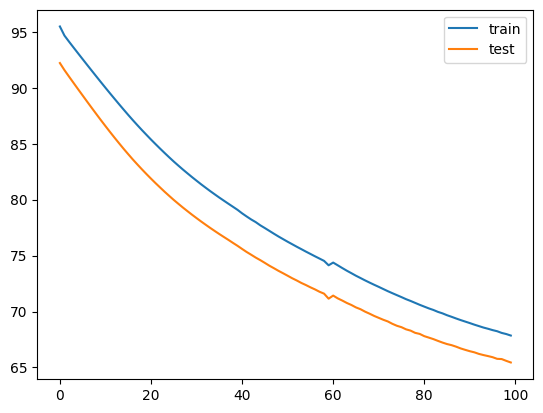

In [ ]:
# Build and train the model
input_shape=(train_X.shape[1], train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance lstm_model)
lstm_model = build_lstm_model(input_shape)
# Train the new model using train_model method with params lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0
train_model(lstm_model, train_X, train_y, test_X, test_y, epochs=100, batch_size=72, verbose=0)

1096/1096 [==============================] - 2s 2ms/step
RMSE: 102.288


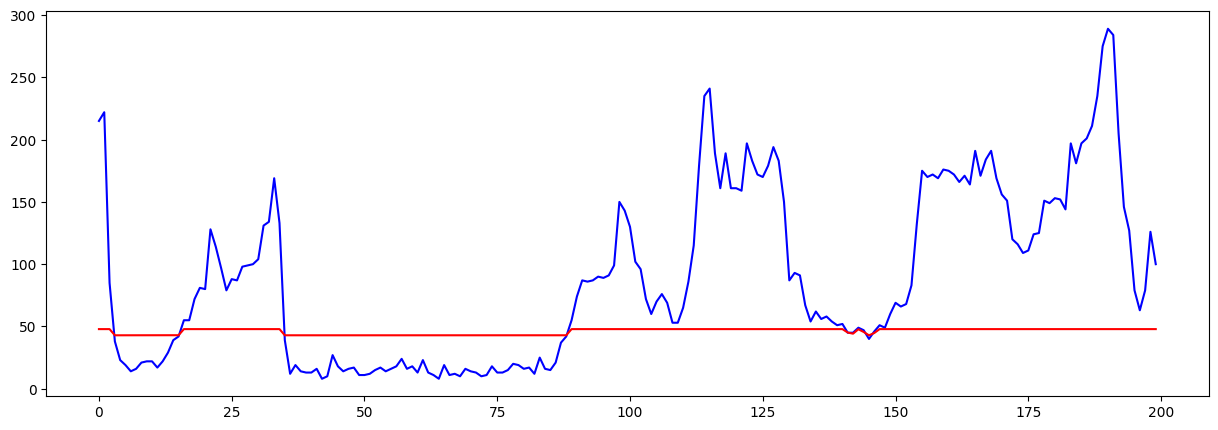

In [ ]:
# make the prediction of test_X (store in lstm_yhat)
lstm_yhat = lstm_model.predict(test_X)
# compute performance
compute_performance(test_y, lstm_yhat, start_t=365*24, end_t=365*24+200)

#### LSTM trained with scaling data

In [ ]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values)

(8760, 1, 32) (8760,) (35061, 1, 32) (35061,)


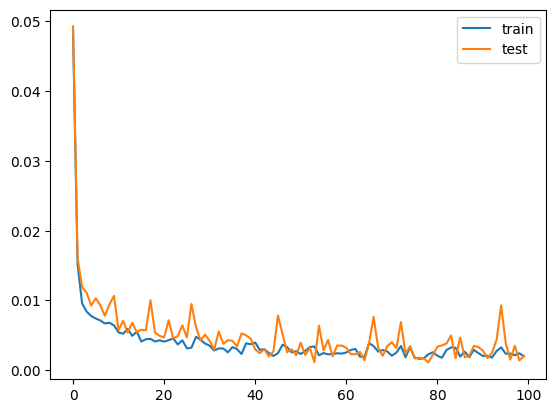

In [ ]:
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
input_shape_scaled = (scaled_train_X.shape[1], scaled_train_X.shape[2])
lstm_model_scaled = build_lstm_model(input_shape_scaled)

# Train the new model using train_model method as previousely using the new scaled data
train_model(lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=100, batch_size=72, verbose=0)

1096/1096 [==============================] - 2s 2ms/step
RMSE: 2.647


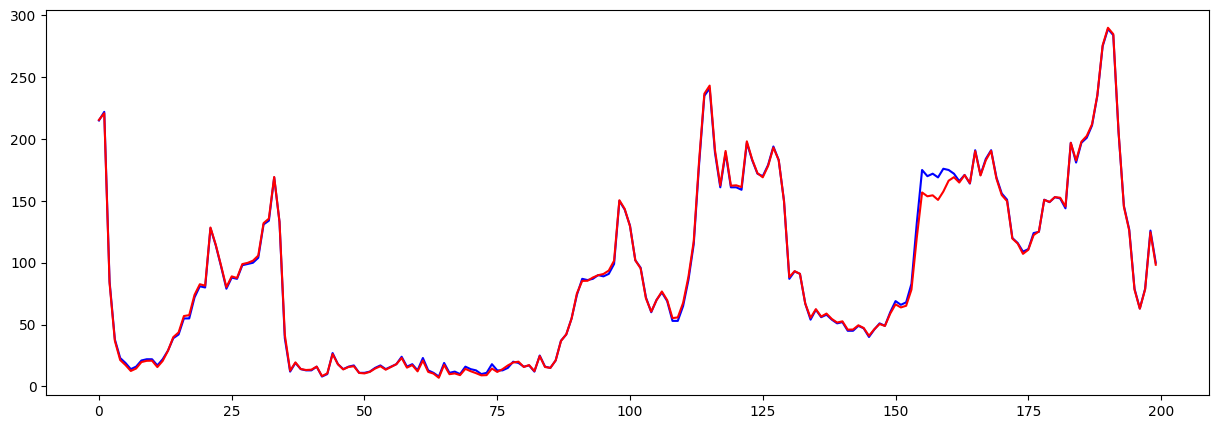

In [ ]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_test_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]

# make a prediction
lstm_scaled_yhat = lstm_model_scaled.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, lstm_scaled_yhat)
compute_performance(test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

#### Build an Stacked LSTM model

Stacked LSTM model refers to stacking multiple hidden LSTM layers one on top of another.

In [ ]:
def build_stacked_lstm_model(input_shape, nb_neurons = 50):
  model = Sequential()
  # Add an LSTM layer with nb_neurons and input_shape=input_shape and return_sequences=True (required sequences needed for next LSTM Bloc)
  model.add(LSTM(nb_neurons, input_shape=input_shape, return_sequences=True))

  # Add an additional LSTM layer with nb_neurons and 'relu' activation function
  model.add(LSTM(nb_neurons, activation='relu'))

  # Add a Dense layer with one output neuron
  model.add(Dense(1))
  # Train the model
  model.compile(loss='mae', optimizer='adam')

  return model



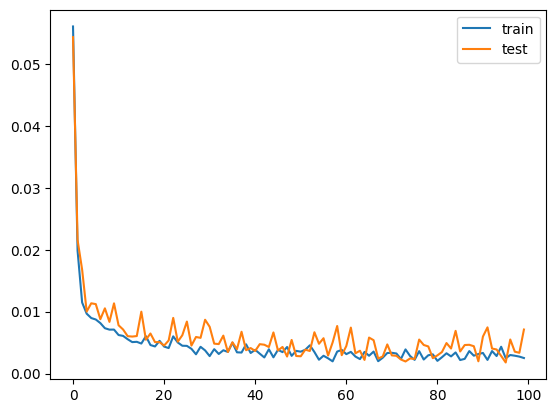

In [ ]:
input_shape = (scaled_train_X.shape[1], scaled_train_X.shape[2])
# Build the new stacked_lstm_model
stacked_lstm_model = build_stacked_lstm_model(input_shape)
# Train the model stacked_lstm_model
train_model(stacked_lstm_model, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y, epochs=100, batch_size=72, verbose=0)

1096/1096 [==============================] - 2s 2ms/step
RMSE: 138.690


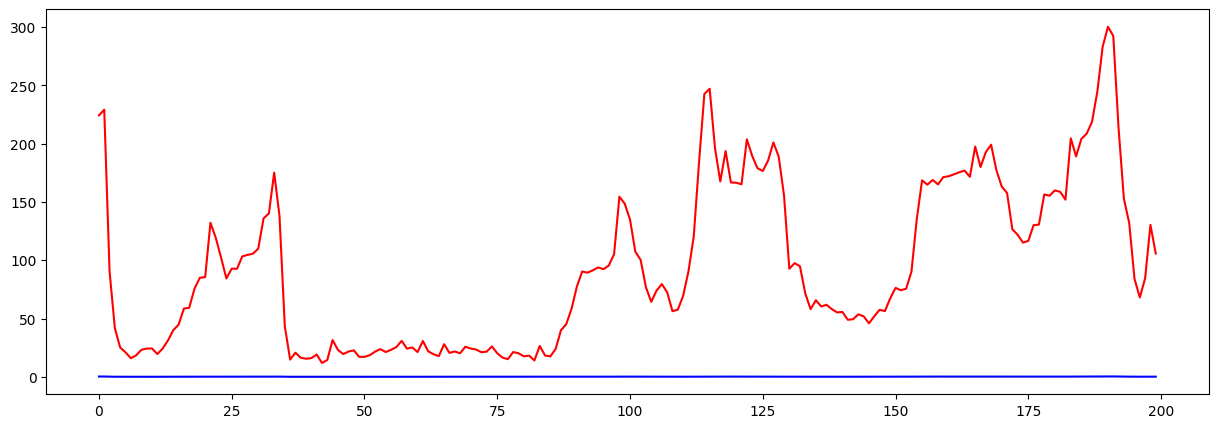

In [ ]:
# make a prediction with stacked_lstm_model using scaled_test_X (output in variable scaled_stacked_lstm_yhat)
scaled_stacked_lstm_yhat = stacked_lstm_model.predict(scaled_test_X)
# compute performance
inv_yhat = invert_scaling(scaled_test_X, scaled_stacked_lstm_yhat)
compute_performance(scaled_test_y, inv_yhat, start_t=365*24, end_t=365*24+200)

## Assignment: Work to improve the performance - try different strategies:
* Hyperparameters tuning
* Test other models:
 - Eg. 1D-ConvNet LSTM, Bidirectional

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Define the end of the current sequence.
        end_ix = i + n_steps
        # Gather input and output parts of the pattern
        seq_X, seq_y = data[i:end_ix, :-1], data[end_ix - 1, -1]
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Convert DataFrame to numpy array
data_values = data_Xy.values
n_steps = 24

# Create sequences
X, y = create_sequences(data_values, n_steps)

print(X.shape, y.shape)


# Assuming you know the index that splits the training and test data
n_train_hours = 365 * 24  # Example: First year as training
X_train1, X_test1 = X[:n_train_hours], X[n_train_hours:]
y_train1, y_test1 = y[:n_train_hours], y[n_train_hours:]

print(X_train1.shape, y_train1.shape)
print(X_test1.shape, y_test1.shape)


(43797, 24, 32) (43797,)
(8760, 24, 32) (8760,)
(35037, 24, 32) (35037,)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten

def build_cnn_lstm_model(input_shape, filters=64, kernel_size=5, nb_neurons=100):
    model = Sequential()
    # 1D Convolutional layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    # LSTM layer
    model.add(LSTM(nb_neurons, activation='relu'))
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model







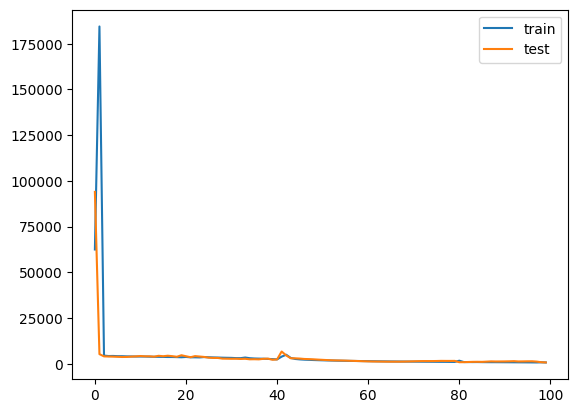

In [ ]:
input_shape = (X_train1.shape[1], X_train1.shape[2])

# Build the model
cnn_lstm_model = build_cnn_lstm_model(input_shape)
# Train the model stacked_lstm_model
train_model(cnn_lstm_model, X_train1, y_train1, X_test1, y_test1, epochs=100, batch_size=72)

1095/1095 [==============================] - 7s 7ms/step
RMSE: 26.616


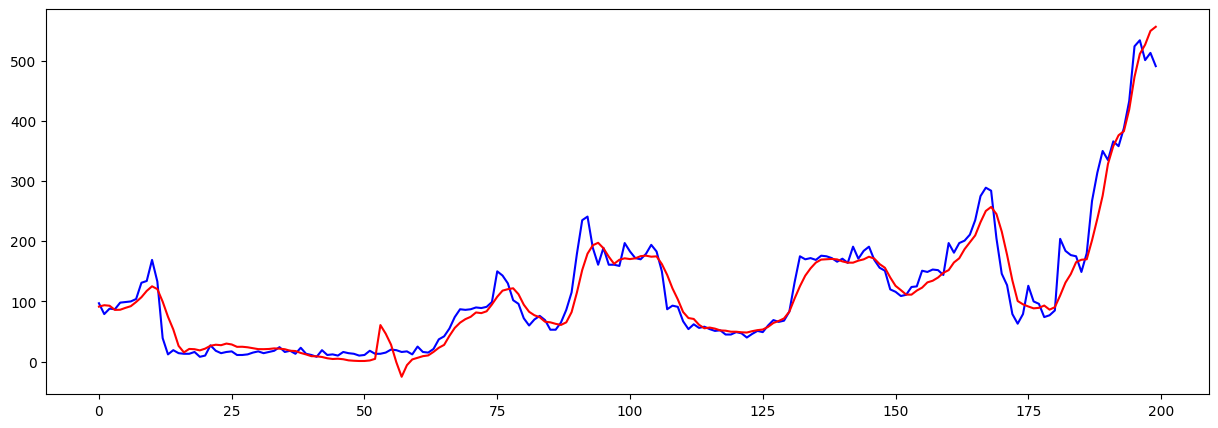

In [ ]:
# make the prediction of test_X (store in lstm_yhat)
cnnlstm_yhat = cnn_lstm_model.predict(X_test1)
# compute performance
compute_performance(y_test1, cnnlstm_yhat, start_t=365*24, end_t=365*24+200)

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense

def build_bidirectional_lstm_model(input_shape, nb_neurons=25):
    model = Sequential()
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(nb_neurons, activation='relu'), input_shape=input_shape))
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


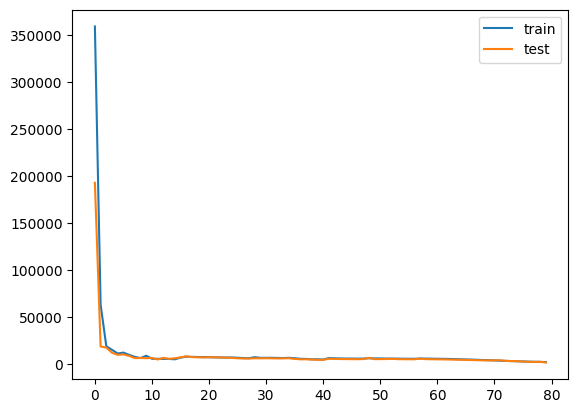

In [ ]:
input_shape = (X_train1.shape[1], X_train1.shape[2])

# Build the model
build_bidirectional_lstm = build_bidirectional_lstm_model(input_shape)
# Train the model stacked_lstm_model
train_model(build_bidirectional_lstm, X_train1, y_train1, X_test1, y_test1, epochs=80, batch_size=64)

1095/1095 [==============================] - 6s 5ms/step
RMSE: 45.346


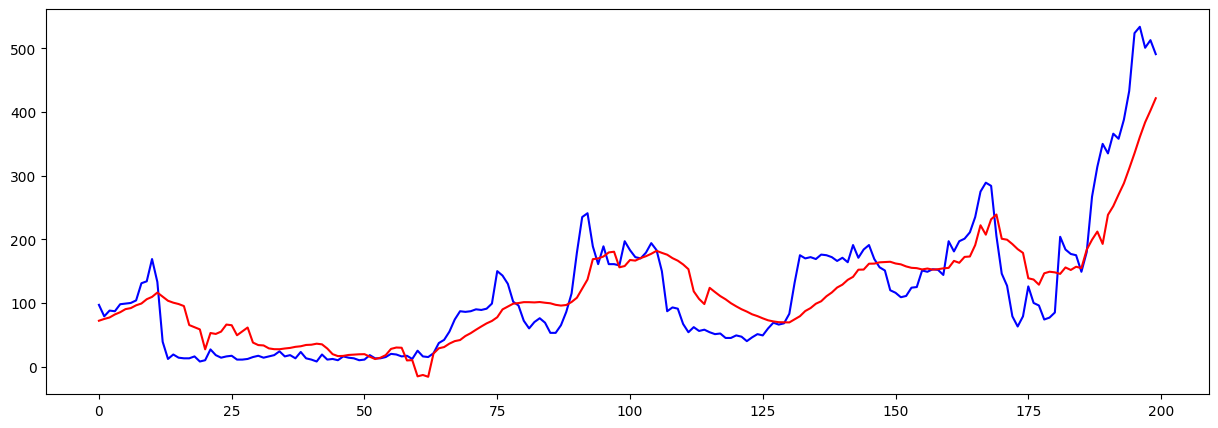

In [ ]:
# make the prediction of test_X (store in lstm_yhat)
cnnlstm_yhat = build_bidirectional_lstm.predict(X_test1)
# compute performance
compute_performance(y_test1, cnnlstm_yhat, start_t=365*24, end_t=365*24+200)